# Homework 9

The goal of this HW is simple. Duplicate (repeat all parts of) homework 8 problem 2 using neural networks. Perform an appropriate contrast of your regression results versus using 

i.) a neural network with 2 hidden nodes and 

ii.) 4 hidden nodes over 2 layers with 2 hidden nodes in each layer. 

All layers should be full connectected, MSE the loss function, a linear output activation layer and RELUs otherwise.

You should return an ipynb nothebook with your code and a final table contrasting the different error rates of the different approaches you tried.

In [1]:
import pandas as pd
import numpy as np
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Read in the data and display rows
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
# df.head(4)

Consider US as country A and clean the dataset

In [3]:
# Choose a country ('US')
country = 'US'
df_country = df[df['Country/Region'] == country]

df_country = df_country.drop(columns=['Lat', 'Long'])

# Sum cases across different provinces/states for the US
df_country = df_country.sum(numeric_only=True, axis=0)

# Convert the series to a DataFrame and reset the index
df_country = pd.DataFrame(df_country).reset_index()
df_country.columns = ['Date', 'Cases']

me =df_country['Cases'].mean()
sd = df_country['Cases'].std()
df_country['std_Cases'] = (df_country['Cases'] - me)/sd

In [4]:
# Convert from Cumulative to Daily Cases
covid_data_daily = df_country['std_Cases'].diff()
df_country['Daily'] = covid_data_daily

# Reset the index to represent days since the outbreak onset (t=0)
df_country = df_country.reset_index(drop=True)

# Create lagged variables (up to 5 days) -- note the lagged case variables refer to daily case counts
for i in range(1, 6):
    df_country[f'Cases_lag{i}'] = df_country['Daily'].shift(i)

# Drop rows with NaN values caused by lagging
df_country = df_country.dropna()
df_country.head()

# Define dependent and independent variables
y = df_country['Daily']
X = df_country[['Cases_lag1', 'Cases_lag2', 'Cases_lag3', 'Cases_lag4', 'Cases_lag5']]

In [5]:
print(df_country.columns)
print(df_country.head(2))

Index(['Date', 'Cases', 'std_Cases', 'Daily', 'Cases_lag1', 'Cases_lag2',
       'Cases_lag3', 'Cases_lag4', 'Cases_lag5'],
      dtype='object')
      Date  Cases  std_Cases         Daily  Cases_lag1    Cases_lag2  \
6  1/28/20      5  -1.290768  0.000000e+00         0.0  8.224834e-08   
7  1/29/20      6  -1.290768  2.741611e-08         0.0  0.000000e+00   

     Cases_lag3    Cases_lag4    Cases_lag5  
6  0.000000e+00  2.741611e-08  0.000000e+00  
7  8.224834e-08  0.000000e+00  2.741611e-08  


In [6]:
print(X.head())

      Cases_lag1    Cases_lag2    Cases_lag3    Cases_lag4    Cases_lag5
6   0.000000e+00  8.224834e-08  0.000000e+00  2.741611e-08  0.000000e+00
7   0.000000e+00  0.000000e+00  8.224834e-08  0.000000e+00  2.741611e-08
8   2.741611e-08  0.000000e+00  0.000000e+00  8.224834e-08  0.000000e+00
9   0.000000e+00  2.741611e-08  0.000000e+00  0.000000e+00  8.224834e-08
10  5.483223e-08  0.000000e+00  2.741611e-08  0.000000e+00  0.000000e+00


First, consider the whole dataset

In [7]:
n = len(df_country)
# change DF to numpy.array and then to tensor
std_y = torch.from_numpy(df_country['Daily'].astype(float).to_numpy())
std_X = torch.from_numpy(df_country.iloc[:,4:].astype(float).to_numpy())

# change to float
std_y = std_y.float()
std_X = std_X.float()

# change the shape of Y from [1137]-->[1137,1]
std_y = std_y.unsqueeze(1)

print(f"std_y shape: {std_y.shape}")
print(f"std_X shape: {std_X.shape}")
print(f"n: {n}")

std_y shape: torch.Size([1137, 1])
std_X shape: torch.Size([1137, 5])
n: 1137


In [8]:
np.random.seed(3468)
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)
print(model)
print("displaying parameters ",
      list(model.parameters()))  # why it has output already? is this randomly assigned? not sure about the number of parameters

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred = model(std_X)

    # the loss for this itneration
    loss = loss_fn(y_pred, std_y)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    # Zero out the gradient 
    optimizer.zero_grad()

    # Backprop
    loss.backward()

  # Optimization step
    optimizer.step()

# present the final parameters
for param in model.parameters():
    print(param)

Sequential(
  (0): Linear(in_features=5, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
displaying parameters  [Parameter containing:
tensor([[-0.0183, -0.2096,  0.1064, -0.0823, -0.1721],
        [ 0.3135,  0.0174,  0.4381, -0.0624, -0.0252]], requires_grad=True), Parameter containing:
tensor([0.0965, 0.2102], requires_grad=True), Parameter containing:
tensor([[ 0.5499, -0.5882]], requires_grad=True), Parameter containing:
tensor([-0.5977], requires_grad=True)]
999 tensor(0.0191, grad_fn=<MseLossBackward0>)
1999 tensor(0.0189, grad_fn=<MseLossBackward0>)
2999 tensor(0.0187, grad_fn=<MseLossBackward0>)
3999 tensor(0.0186, grad_fn=<MseLossBackward0>)
4999 tensor(0.0185, grad_fn=<MseLossBackward0>)
5999 tensor(0.0183, grad_fn=<MseLossBackward0>)
6999 tensor(0.0182, grad_fn=<MseLossBackward0>)
7999 tensor(0.0181, grad_fn=<MseLossBackward0>)
8999 tensor(0.0179, grad_fn=<MseLossBackward0>)
9999 tensor(0.0178, grad_fn=<MseLossBackward0>)
Pa

In [9]:
std_y_pred = model(std_X)
std_y_pred = y_pred.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y = std_y.numpy().reshape(-1)
# Compute residuals
std_res_full = std_y - std_y_pred

In [10]:
# change DF to numpy.array and then to tensor
std_y2 = torch.from_numpy(df_country['Daily'].astype(float).to_numpy())
std_X2 = torch.from_numpy(df_country.iloc[:,4:].astype(float).to_numpy())

# change to float
std_y2 = std_y2.float()
std_X2 = std_X2.float()

# change the shape of Y from [1137]-->[1137,1]
std_y2 = std_y2.unsqueeze(1)

print(f"std_y2 shape: {std_y2.shape}")
print(f"std_X2 shape: {std_X2.shape}")
print(f"n: {n}")

std_y2 shape: torch.Size([1137, 1])
std_X2 shape: torch.Size([1137, 5])
n: 1137


In [11]:
np.random.seed(6856)
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 2),  # 2 nodes to 2 nodes  ??
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

print("displaying parameters ",
      list(model.parameters())) 

#loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred2 = model(std_X2)

    # the loss for this itneration
    loss = loss_fn(y_pred2, std_y2)
    if t % 1000 == 999:
        print(t, loss)  

    ## Zero out the gradient before adding them up [before we do the back propagation step]
    ## when we accumulate with a back propagation step, it does not add to the previous value.
    optimizer.zero_grad()

    ## Backprop
    loss.backward()

  ## Optimization step
    optimizer.step()


for param in model.parameters():
    print(param)


displaying parameters  [Parameter containing:
tensor([[ 0.3198,  0.1382, -0.4465, -0.4328,  0.3217],
        [ 0.4234, -0.4107, -0.4323, -0.1137,  0.0428]], requires_grad=True), Parameter containing:
tensor([0.1006, 0.2892], requires_grad=True), Parameter containing:
tensor([[-0.3699,  0.5740],
        [ 0.3854,  0.5052]], requires_grad=True), Parameter containing:
tensor([ 0.6592, -0.3136], requires_grad=True), Parameter containing:
tensor([[-0.6195, -0.4882]], requires_grad=True), Parameter containing:
tensor([-0.6396], requires_grad=True)]
999 tensor(0.0128, grad_fn=<MseLossBackward0>)
1999 tensor(0.0128, grad_fn=<MseLossBackward0>)
2999 tensor(0.0128, grad_fn=<MseLossBackward0>)
3999 tensor(0.0128, grad_fn=<MseLossBackward0>)
4999 tensor(0.0128, grad_fn=<MseLossBackward0>)
5999 tensor(0.0128, grad_fn=<MseLossBackward0>)
6999 tensor(0.0128, grad_fn=<MseLossBackward0>)
7999 tensor(0.0128, grad_fn=<MseLossBackward0>)
8999 tensor(0.0128, grad_fn=<MseLossBackward0>)
9999 tensor(0.0128, 

In [12]:
std_y_pred2 = model(std_X2)
std_y_pred2 = y_pred2.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y2 = std_y2.numpy().reshape(-1)
# Compute residuals
std_res_full2 = std_y2 - std_y_pred2

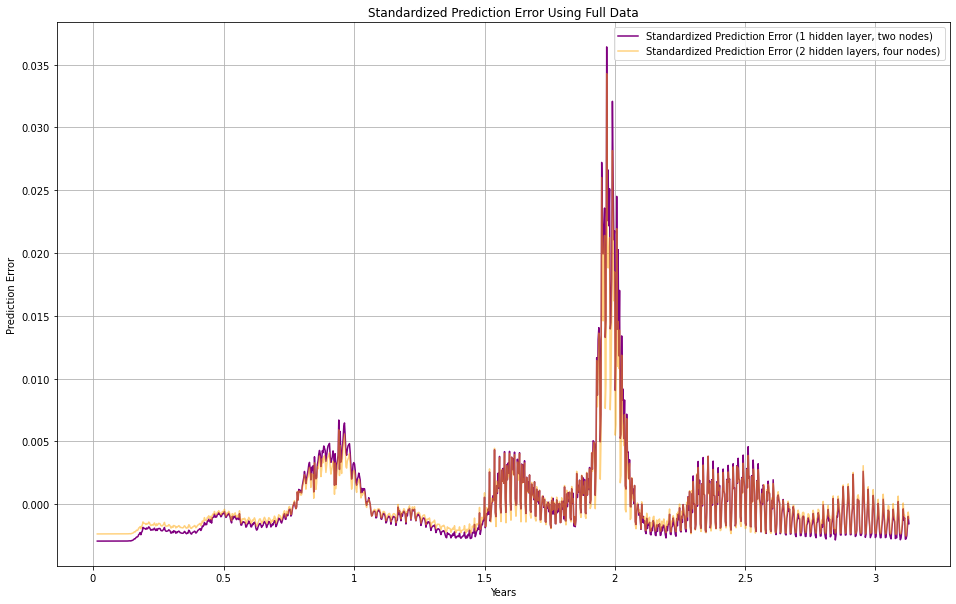

In [13]:
# Create two subplots 1) 1 hidden layer, two nodes 2) 2 hidden layers, four nodes
plt.figure(figsize=(16, 10))
plt.plot(X.index,std_res_full, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
plt.plot(X.index,std_res_full2, label='Standardized Prediction Error (2 hidden layers, four nodes)',color='Orange', alpha=0.5)
plt.xlabel('Years')
plt.xticks([0,183,365,548,730,913,1095],[0,0.5,1,1.5,2,2.5,3])
plt.ylabel('Prediction Error')
plt.title('Standardized Prediction Error Using Full Data')
plt.legend()
plt.grid(True)
plt.show();

Use half as training and half as validation

In [14]:
half_n = len(df_country) // 2
# change DF to numpy.array and then to tensor
std_y_train = torch.from_numpy(df_country.iloc[:half_n,3].astype(float).to_numpy())
std_X_train = torch.from_numpy(df_country.iloc[:half_n,4:].astype(float).to_numpy())

std_y_test = torch.from_numpy(df_country.iloc[half_n:,3].astype(float).to_numpy())
std_X_test = torch.from_numpy(df_country.iloc[half_n:,4:].astype(float).to_numpy())

# change to float
std_y_train = std_y_train.float()
std_X_train = std_X_train.float()

std_y_test = std_y_test.float()
std_X_test = std_X_test.float()

# change the shape of Y from [1137]-->[1137,1]
std_y_train = std_y_train.unsqueeze(1)

print(f"std_y_train shape: {std_y_train.shape}")
print(f"std_X_train shape: {std_X_train.shape}")
print(f"half n: {half_n}")

print(f"std_y_test shape: {std_y_test.shape}")
print(f"std_X_test shape: {std_X_test.shape}")

std_y_train shape: torch.Size([568, 1])
std_X_train shape: torch.Size([568, 5])
half n: 568
std_y_test shape: torch.Size([569])
std_X_test shape: torch.Size([569, 5])


In [15]:
# Build a class for the neuro network with 1 hidden layer and two nodes
import torch
class oneLayer(torch.nn.Module):
    def __init__(self):
        super(oneLayer, self).__init__()

        self.linear1 = torch.nn.Linear(5,2)
        self.ReLU = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(2,1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x
    
np.random.seed(429)  # set the seed for the starting value
model = oneLayer()
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.2098, -0.4444, -0.1786, -0.0966,  0.3447],
        [ 0.0114, -0.3060,  0.1199,  0.3855, -0.0805]], requires_grad=True), Parameter containing:
tensor([-0.2442,  0.1836], requires_grad=True), Parameter containing:
tensor([[0.5740, 0.1099]], requires_grad=True), Parameter containing:
tensor([-0.6812], requires_grad=True)]


In [16]:
#loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred_train = model(std_X_train)

    # the loss for this itneration
    loss = loss_fn(y_pred_train, std_y_train)
    if t % 1000 == 999:
        print(t, loss)  

    ## Zero out the gradient before adding them up [before we do the back propagation step]
    ## when we accumulate with a back propagation step, it does not add to the previous value.
    optimizer.zero_grad()

    ## Backprop
    loss.backward()

  ## Optimization step
    optimizer.step()


for name, param in model.named_parameters():
    print(f"{name}: {param.data}")


999 tensor(0.0016, grad_fn=<MseLossBackward0>)
1999 tensor(0.0016, grad_fn=<MseLossBackward0>)
2999 tensor(0.0016, grad_fn=<MseLossBackward0>)
3999 tensor(0.0016, grad_fn=<MseLossBackward0>)
4999 tensor(0.0016, grad_fn=<MseLossBackward0>)
5999 tensor(0.0016, grad_fn=<MseLossBackward0>)
6999 tensor(0.0016, grad_fn=<MseLossBackward0>)
7999 tensor(0.0016, grad_fn=<MseLossBackward0>)
8999 tensor(0.0016, grad_fn=<MseLossBackward0>)
9999 tensor(0.0016, grad_fn=<MseLossBackward0>)
linear1.weight: tensor([[ 0.2098, -0.4444, -0.1786, -0.0966,  0.3447],
        [ 0.0123, -0.3050,  0.1208,  0.3866, -0.0796]])
linear1.bias: tensor([-0.2442,  0.2871])
linear2.weight: tensor([[0.5740, 0.2480]])
linear2.bias: tensor([-0.0695])


In [17]:
# calculate 
std_y_test_pred = model(std_X_test)
std_y_test_pred = std_y_test_pred .detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y_test_pred = std_y_test_pred.reshape(-1)
# Compute residuals
std_res_half = std_y_test - std_y_test_pred 

In [30]:
# Build a class for the neuro network with 2 hidden layers and four nodes
import torch
class twoLayer(torch.nn.Module):
    def __init__(self):
        super(twoLayer, self).__init__()

        self.linear1 = torch.nn.Linear(5,2)
        self.ReLU = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(2,2)
        self.ReLU = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(2,1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        x = self.ReLU(x)
        x = self.linear3(x)
        return x
    
np.random.seed(867567)  # set the seed for the starting value
model2 = twoLayer()
print(f"linear 1: {list(model2.linear1.named_parameters())}")
print(f"linear 2: {list(model2.linear2.named_parameters())}")
print(f"linear 3: {list(model2.linear3.named_parameters())}")

linear 1: [('weight', Parameter containing:
tensor([[ 0.3407,  0.2248, -0.2827,  0.1957,  0.3317],
        [-0.0822,  0.1070, -0.2742,  0.3495,  0.3986]], requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.1665, -0.0377], requires_grad=True))]
linear 2: [('weight', Parameter containing:
tensor([[-0.5278, -0.6059],
        [ 0.1322,  0.4423]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.1933, 0.2048], requires_grad=True))]
linear 3: [('weight', Parameter containing:
tensor([[ 0.4352, -0.6077]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.1099], requires_grad=True))]


In [31]:
#loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred_train2 = model2(std_X_train)

    # the loss for this itneration
    loss = loss_fn(y_pred_train2, std_y_train)
    if t % 1000 == 999:
        print(t, loss)  

    ## Zero out the gradient before adding them up [before we do the back propagation step]
    ## when we accumulate with a back propagation step, it does not add to the previous value.
    optimizer.zero_grad()

    ## Backprop
    loss.backward()

  ## Optimization step
    optimizer.step()


for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

999 tensor(0.1424, grad_fn=<MseLossBackward0>)
1999 tensor(0.1424, grad_fn=<MseLossBackward0>)
2999 tensor(0.1424, grad_fn=<MseLossBackward0>)
3999 tensor(0.1424, grad_fn=<MseLossBackward0>)
4999 tensor(0.1424, grad_fn=<MseLossBackward0>)
5999 tensor(0.1424, grad_fn=<MseLossBackward0>)
6999 tensor(0.1424, grad_fn=<MseLossBackward0>)
7999 tensor(0.1424, grad_fn=<MseLossBackward0>)
8999 tensor(0.1424, grad_fn=<MseLossBackward0>)
9999 tensor(0.1424, grad_fn=<MseLossBackward0>)
linear1.weight: tensor([[ 0.2098, -0.4444, -0.1786, -0.0966,  0.3447],
        [ 0.0123, -0.3050,  0.1208,  0.3866, -0.0796]])
linear1.bias: tensor([-0.2442,  0.2871])
linear2.weight: tensor([[0.5740, 0.2480]])
linear2.bias: tensor([-0.0695])


In [32]:
# calculate 
std_y_test_pred2 = model2(std_X_test)
std_y_test_pred2 = std_y_test_pred2 .detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y_test_pred2 = std_y_test_pred2.reshape(-1)
# Compute residuals
std_res_half2 = std_y_test - std_y_test_pred2 

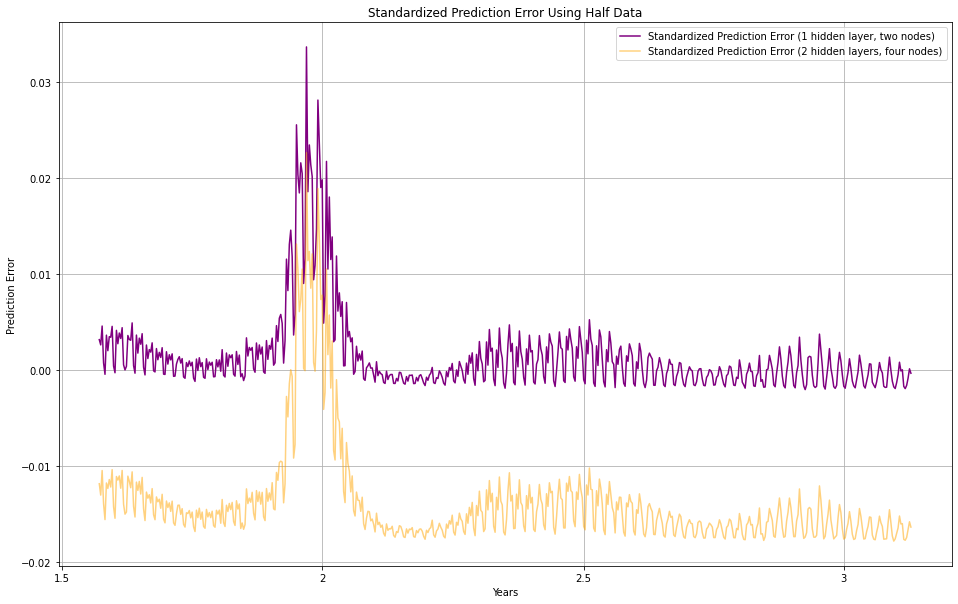

In [33]:
# Create two subplots 1) 1 hidden layer, two nodes 2) 2 hidden layers, four nodes
plt.figure(figsize=(16, 10))
plt.plot(X.index[half_n:],std_res_half, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
plt.plot(X.index[half_n:],std_res_half2, label='Standardized Prediction Error (2 hidden layers, four nodes)',color='Orange', alpha=0.5)
plt.xlabel('Years')
plt.xticks([548,730,913,1095],[1.5,2,2.5,3])
plt.ylabel('Prediction Error')
plt.title('Standardized Prediction Error Using Half Data')
plt.legend()
plt.grid(True)
plt.show();